# Gibbs free energy expressions for IN625 from ternary CALPHAD DB

This notebook extracts relevant thermodynamic functions necessary for the phase-field model of solid-state transformations in additive superalloy 625, represented as a ternary (Mo-Nb-Ni) with γ, δ, and μ phases competing. The BCC phase is included for ternary isothermal phase diagram generation, only -- it is not used in simulations.

The phase field model requires Gibbs free energies as functions of system compositions $x_\mathrm{Mo}$, $x_\mathrm{Nb}$, $x_\mathrm{Ni}$. The Calphad database, Thermotech Ni..., represents these energies as functions of sublattice compositions in each phase. To avoid solving for internal phase equilibrium at each point in the simulation, the following approximations have been made:
* γ: FCC (Mo,Nb,Ni) has only one sublattice, no changes necessary
* BCC: (Mo,Nb,Ni) has only one sublattice, no changes necessary
* δ:  two sublattices, approximately stoichiometric $\mathrm{(Nb,Ni)_3(Mo,Nb,Ni) \rightarrow Ni_3(Mo,Nb,Ni)}$
* μ: three sublattices $\mathrm{Ni'_6(Mo'',Nb'')_4(Mo''',Nb''',Ni''')_3 \rightarrow Ni'_6(Mo'',Nb'')_4(Mo'',Nb''',Ni''')_3}$, *viz.* the sublattice compositions of Mo are set equal, $y_\mathrm{Mo}'' = y_\mathrm{Mo}'''$. This allows for a unique mapping from sublattice $y$ to system $x$ composition. Phases such as this tend to have sharp Gibbs energies with cusp-like minima at the stoichiometric composition, and high energies far away. This approximation preserves the behavior near stoichiometry, but introduces high error far away -- a tolerable situation in our opinion.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import fsolve
from sympy.utilities.lambdify import lambdify
from pycalphad import Database, calculate, Model
from sympy.utilities.codegen import codegen
from sympy.parsing.sympy_parser import parse_expr
from sympy import diff, simplify, symbols, sympify

seventh = 13.0/7
third = 13.0/3
quarter = 3.0/4
rt32 = np.sqrt(3)/2
epsilon = 1e-8 # tolerance for comparing floating-point numbers to zero
temp = 870.0 + 273.15 # 1143 Kelvin

In [2]:
#tdb = Database('mc_ni_v2.033.tdb')
#tdb = Database('monbni-simple.tdb')
tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC.tdb')
#tdb = Database('Thermotech_Mo-Nb-Ni_FCC-delta-mu-BCC_simple.tdb')

In [3]:
phases = ['FCC_A1', 'DELTA', 'MU_PHASE', 'BCC_A2', 'LIQUID']
elements = ['MO', 'NB', 'NI', 'VA']

## Export Gibbs functions using SymPy

In [4]:
c_gamma = list(set([i for c in tdb.phases['FCC_A1'].constituents for i in c]))
m_gamma = Model(tdb, c_gamma, 'FCC_A1')
s_gamma = 1 # sites in formula unit
g_gamma = parse_expr(str(m_gamma.ast)) / s_gamma
print g_gamma

8.3145*T*(1.0*Piecewise((FCC_A10MO*log(FCC_A10MO), FCC_A10MO > 1.0e-13), (0, True))/(-1.0*FCC_A11VA + 2.0) + 1.0*Piecewise((FCC_A10NB*log(FCC_A10NB), FCC_A10NB > 1.0e-13), (0, True))/(-1.0*FCC_A11VA + 2.0) + 1.0*Piecewise((FCC_A10NI*log(FCC_A10NI), FCC_A10NI > 1.0e-13), (0, True))/(-1.0*FCC_A11VA + 2.0)) + 8.3145*T*Piecewise((-0.00174491240370669*T**15/(FCC_A10NI*FCC_A11VA*Piecewise((-0.333333333333333, FCC_A10NI*FCC_A11VA*Piecewise((633, And(T < 6000.0, T >= 298.15)), (0, True)) <= 0), (1.00000000000000, True))*Piecewise((633, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.01)**15 - 0.00775516623869638*T**9/(FCC_A10NI*FCC_A11VA*Piecewise((-0.333333333333333, FCC_A10NI*FCC_A11VA*Piecewise((633, And(T < 6000.0, T >= 298.15)), (0, True)) <= 0), (1.00000000000000, True))*Piecewise((633, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.01)**9 - 0.174491240370669*T**3/(FCC_A10NI*FCC_A11VA*Piecewise((-0.333333333333333, FCC_A10NI*FCC_A11VA*Piecewise((633, And(T < 6000.0, T >= 298.15)), (0, True)

In [5]:
c_delta = list(set([i for c in tdb.phases['DELTA'].constituents for i in c]))
m_delta = Model(tdb, c_delta, 'DELTA')
s_delta = 4 # sites in formula unit
g_delta = parse_expr(str(m_delta.ast)) / s_delta
print g_delta

0.0625*DELTA0NB*DELTA0NI*DELTA1MO*Piecewise((45000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.0625*DELTA0NB*DELTA0NI*DELTA1NB*Piecewise((45000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.0625*DELTA0NB*DELTA0NI*DELTA1NI*Piecewise((45000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.0625*DELTA0NB*DELTA1MO*DELTA1NI*Piecewise((25000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.0625*DELTA0NB*DELTA1MO*Piecewise((-1.309265e-10*T**4 - 4.84074e-7*T**3 - 0.002832971*T**2 - 102.97744*T*log(T) + 565.256125*T + 8245.639 + 346009/T, And(T < 2750.0, T >= 298.15)), (-1.309265e-10*T**4 + 5.66283e-7*T**3 - 0.003443396*T**2 - 148.87414*T*log(T) + 954.282229*T - 79204.202 + 65812/T + 4.58472e+32/T**9, And(T < 2896.0, T >= 2750.0)), (-167.94829*T*log(T) + 1105.92227*T - 102014.31 - 4.390843e+33/T**9, And(T < 6000.0, T >= 2896.0)), (0, True)) + 0.0625*DELTA0NB*DELTA1NB*DELTA1NI*Piecewise((7000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.0625*DELTA0NB*DELTA1NB*Piecewise((-1.400476e-6*T**3 + 0.00

In [6]:
c_mu = list(set([i for c in tdb.phases['MU_PHASE'].constituents for i in c]))
m_mu = Model(tdb, c_mu, 'MU_PHASE')
s_mu = 13 # sites in formula unit
g_mu = parse_expr(str(m_mu.ast)) / s_mu
print g_mu

0.00591715976331361*MU_PHASE0NI*MU_PHASE1MO*MU_PHASE2MO*MU_PHASE2NI*Piecewise((80*T - 145000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.00591715976331361*MU_PHASE0NI*MU_PHASE1MO*MU_PHASE2MO*Piecewise((-9.164855e-10*T**4 + 3.963981e-6*T**3 - 0.053147972*T**2 - 297.52498*T*log(T) + 1630.5619*T - 97489.068 + 460684/T, And(T < 1728.0, T >= 298.15)), (-9.164855e-10*T**4 + 3.963981e-6*T**3 - 0.024103772*T**2 - 423.54898*T*log(T) + 2598.2479*T - 233458.044 + 460684/T + 6.76524e+31/T**9, And(T < 2896.0, T >= 1728.0)), (-557.06803*T*log(T) + 3659.72822*T - 393128.8 - 3.387755e+34/T**9, And(T < 6000.0, T >= 2896.0)), (0, True)) + 0.00591715976331361*MU_PHASE0NI*MU_PHASE1MO*MU_PHASE2NB*MU_PHASE2NI*Piecewise((25*T - 90000, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.00591715976331361*MU_PHASE0NI*MU_PHASE1MO*MU_PHASE2NB*Piecewise((-5.23706e-10*T**4 + 1.214775e-6*T**3 - 0.042207359*T**2 - 306.24586*T*log(T) + 1676.3678*T - 274012.507 + 543445/T, And(T < 1728.0, T >= 298.15)), (-5.23706e-10*T**

In [7]:
c_bcc = list(set([i for c in tdb.phases['BCC_A2'].constituents for i in c]))
m_bcc = Model(tdb, c_bcc, 'BCC_A2')
s_bcc = 1 # sites in formula unit
g_bcc = parse_expr(str(m_bcc.ast)) / s_bcc
print g_bcc

8.3145*T*(1.0*Piecewise((BCC_A20MO*log(BCC_A20MO), BCC_A20MO > 1.0e-13), (0, True))/(-3.0*BCC_A21VA + 4.0) + 1.0*Piecewise((BCC_A20NB*log(BCC_A20NB), BCC_A20NB > 1.0e-13), (0, True))/(-3.0*BCC_A21VA + 4.0) + 1.0*Piecewise((BCC_A20NI*log(BCC_A20NI), BCC_A20NI > 1.0e-13), (0, True))/(-3.0*BCC_A21VA + 4.0)) + 8.3145*T*Piecewise((-0.00153008346379333*T**15/(BCC_A20NI*BCC_A21VA*Piecewise((-1.00000000000000, BCC_A20NI*BCC_A21VA*Piecewise((575, And(T < 6000.0, T >= 298.15)), (0, True)) <= 0), (1.00000000000000, True))*Piecewise((575, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.01)**15 - 0.00680037095019259*T**9/(BCC_A20NI*BCC_A21VA*Piecewise((-1.00000000000000, BCC_A20NI*BCC_A21VA*Piecewise((575, And(T < 6000.0, T >= 298.15)), (0, True)) <= 0), (1.00000000000000, True))*Piecewise((575, And(T < 6000.0, T >= 298.15)), (0, True)) + 0.01)**9 - 0.153008346379333*T**3/(BCC_A20NI*BCC_A21VA*Piecewise((-1.00000000000000, BCC_A20NI*BCC_A21VA*Piecewise((575, And(T < 6000.0, T >= 298.15)), (0, True)) <

## Convert sublattice to phase composition (y to x)

In [8]:
# Declare sublattice variables used in Pycalphad expressions
FCC_A10MO, FCC_A10NB, FCC_A10NI, FCC_A11VA = symbols('FCC_A10MO FCC_A10NB FCC_A10NI FCC_A11VA')
DELTA0NI, DELTA0NB, DELTA1MO, DELTA1NB, DELTA1NI = symbols('DELTA0NI DELTA0NB DELTA1MO DELTA1NB DELTA1NI')
MU_PHASE0NI, MU_PHASE1MO, MU_PHASE1NB, MU_PHASE2MO, MU_PHASE2NB, MU_PHASE2NI = symbols('MU_PHASE0NI MU_PHASE1MO MU_PHASE1NB MU_PHASE2MO MU_PHASE2NB MU_PHASE2NI')
BCC_A20MO, BCC_A20NB, BCC_A20NI, BCC_A21VA = symbols('BCC_A20MO BCC_A20NB BCC_A20NI BCC_A21VA')
T = symbols('T')

# Declare system variables for target expressions
GAMMA_XMO, GAMMA_XNB, GAMMA_XNI = symbols('GAMMA_XMO GAMMA_XNB GAMMA_XNI')
DELTA_XMO, DELTA_XNB, DELTA_XNI = symbols('DELTA_XMO DELTA_XNB DELTA_XNI')
MU_XMO, MU_XNB, MU_XNI = symbols('MU_XMO MU_XNB MU_XNI')
BCC_XMO, BCC_XNB, BCC_XNI = symbols('BCC_XMO BCC_XNB BCC_XNI')

# Numerically efficient sublattice expressions
GYg = lambdify([FCC_A10MO, FCC_A10NB, FCC_A10NI, FCC_A11VA, T], g_gamma, modules='numpy')
GYd = lambdify([DELTA0NI, DELTA0NB, DELTA1MO, DELTA1NB, DELTA1NI, T], g_delta, modules='numpy')
GYu = lambdify([MU_PHASE0NI, MU_PHASE1MO, MU_PHASE1NB, MU_PHASE2MO, MU_PHASE2NB, MU_PHASE2NI, T], g_mu, modules='numpy')
GYb = lambdify([BCC_A20MO, BCC_A20NB, BCC_A20NI, BCC_A21VA, T], g_bcc, modules='numpy')


In [ ]:
# plot Gibbs energy curves for fixed x_Mo = 2%
# Numerically efficient Gibbs energies
GX = []
GY = []
DX = []
DY = []
UX = []
UY = []
BX = []
BY = []

for xnb in np.linspace(epsilon,1,101):
    xmo = 0.02
    xni = 1-xmo-xnb
    #print "(%4.2f, %4.2f,%5.2f)"%(xmo,xnb,xni)
    if xni>0:
        UX.append(xnb)
        GY.append(GYg(xmo, xnb, xni, 1, temp))
        DY.append(GYd(1, 0, 4*xmo, 4*xnb, 4*(xni-quarter),temp))
        UY.append(GYu(1, 1-seventh*xnb, seventh*xnb, 3-seventh*xnb-third*xni, seventh*xnb, third*xni-2,temp))
        BY.append(GYb(xmo,xnb,xni,1,temp))

plt.figure(figsize=(8, 8))
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$\mathcal{G}$', fontsize=24)
plt.plot(UX, GY, label=r'$\mathcal{G}_\gamma$')
plt.plot(UX, DY, label=r'$\mathcal{G}_\delta$')
plt.plot(UX, UY, label=r'$\mathcal{G}_\mu$')
plt.plot(UX, BY, label=r'$\mathcal{G}_\mathrm{BCC}$')
plt.legend(loc='best')

In [10]:
# Make substitutions

g_gamma = g_gamma.subs({FCC_A10MO: GAMMA_XMO,
                                  FCC_A10NB: GAMMA_XNB,
                                  FCC_A10NI: GAMMA_XNI,
                                  FCC_A11VA: 1,
                                  T: temp}, simultaneous=True)

# Approximate delta as a stoichiometric compound, (Nb,Ni)3(Mo,Nb,Ni) ==> Ni3(Mo,Nb,Ni)
g_delta = g_delta.subs({DELTA0NI: 1,
                                  DELTA0NB: 0,
                                  DELTA1MO: 4*DELTA_XMO,
                                  DELTA1NB: 4*DELTA_XNB,
                                  DELTA1NI: 4*(DELTA_XNI-quarter),
                                  T: temp}, simultaneous=True)

# Substitution made possible by setting y3_Mo=y4_Mo
g_mu = g_mu.subs({MU_PHASE0NI: 1,
                         MU_PHASE1NB: 1 - seventh*MU_XNB,
                         MU_PHASE1MO: seventh*MU_XMO,
                         MU_PHASE2MO: seventh*MU_XMO,
                         MU_PHASE2NB: 3 - seventh*MU_XMO - third*MU_XNI,
                         MU_PHASE2NI: third*MU_XNI - 2,
                         T: temp}, simultaneous=True)

g_bcc = g_bcc.subs({BCC_A20MO: BCC_XMO,
                            BCC_A20NB: BCC_XNB,
                            BCC_A20NI: BCC_XNI,
                            BCC_A21VA: 1,
                            T: temp}, simultaneous=True)

In [11]:
print g_gamma

-36000.0*GAMMA_XMO*GAMMA_XNB + 10880.0*GAMMA_XMO*GAMMA_XNI*(GAMMA_XMO - GAMMA_XNI) - 2009.474*GAMMA_XMO*GAMMA_XNI - 34522.4622528066*GAMMA_XMO - 10000.0*GAMMA_XNB*GAMMA_XNI*(GAMMA_XNB - GAMMA_XNI)**2 + 37099.25*GAMMA_XNB*GAMMA_XNI*(GAMMA_XNB - GAMMA_XNI) - 75550.7*GAMMA_XNB*GAMMA_XNI - 43952.3108269978*GAMMA_XNB - 54642.7769483642*GAMMA_XNI + 9504.720675*Piecewise((GAMMA_XMO*log(GAMMA_XMO), GAMMA_XMO > 1.0e-13), (0, True)) + 9504.720675*Piecewise((GAMMA_XNB*log(GAMMA_XNB), GAMMA_XNB > 1.0e-13), (0, True)) + 9504.720675*Piecewise((GAMMA_XNI*log(GAMMA_XNI), GAMMA_XNI > 1.0e-13), (0, True)) + 9504.720675*Piecewise((-0.476398050706561*GAMMA_XNI*Piecewise((-0.333333333333333, 633*GAMMA_XNI <= 0), (1.00000000000000, True)) + 0.999992473964444 - 260665342.340181/(633*GAMMA_XNI*Piecewise((-0.333333333333333, 633*GAMMA_XNI <= 0), (1.00000000000000, True)) + 0.01)**3 - 2.58535447937765e+25/(633*GAMMA_XNI*Piecewise((-0.333333333333333, 633*GAMMA_XNI <= 0), (1.00000000000000, True)) + 0.01)**9 - 1

In [12]:
print g_delta

6250.0*DELTA_XMO*(4*DELTA_XNI - 3.0) - 56623.2568994748*DELTA_XMO + 1750.0*DELTA_XNB*(4*DELTA_XNI - 3.0) - 80115.2491680226*DELTA_XNB - 50011.8950683642*DELTA_XNI + 594.0450421875*Piecewise((4*DELTA_XMO*log(4*DELTA_XMO), 4*DELTA_XMO > 1.0e-13), (0, True)) + 594.0450421875*Piecewise((4*DELTA_XNB*log(4*DELTA_XNB), 4*DELTA_XNB > 1.0e-13), (0, True)) + 594.0450421875*Piecewise(((4*DELTA_XNI - 3.0)*log(4*DELTA_XNI - 3.0), 4*DELTA_XNI - 3.0 > 1.0e-13), (0, True)) + 37508.9213012732


In [13]:
print g_mu

-1092.81632653061*MU_XMO**2*(4.33333333333333*MU_XNI - 2) - 14145.8201828537*MU_XMO**2 - 588.43956043956*MU_XMO*(-1.85714285714286*MU_XNB + 1)*(4.33333333333333*MU_XNI - 2) - 10121.3928467263*MU_XMO*(-1.85714285714286*MU_XNB + 1) - 674.958791208791*MU_XMO*(4.33333333333333*MU_XNI - 2)*(-1.85714285714286*MU_XMO - 4.33333333333333*MU_XNI + 3) - 7161.76461040114*MU_XMO*(4.33333333333333*MU_XNI - 2) - 9632.65227111159*MU_XMO*(-1.85714285714286*MU_XMO - 4.33333333333333*MU_XNI + 3) - 363.439349112426*(-1.85714285714286*MU_XNB + 1)*(4.33333333333333*MU_XNI - 2)*(-1.85714285714286*MU_XMO - 4.33333333333333*MU_XNI + 3) - 5504.20210558147*(-1.85714285714286*MU_XNB + 1)*(4.33333333333333*MU_XNI - 2) - 5943.62679405278*(-1.85714285714286*MU_XNB + 1)*(-1.85714285714286*MU_XMO - 4.33333333333333*MU_XNI + 3) + 393.686655177515*Piecewise((1.85714285714286*MU_XMO*log(1.85714285714286*MU_XMO), 1.85714285714286*MU_XMO > 1.0e-13), (0, True)) + 224.96380295858*Piecewise(((-1.85714285714286*MU_XNB + 1)*log

In [14]:
print g_bcc

-36000.0*BCC_XMO*BCC_XNB + 46422.0*BCC_XMO*BCC_XNI - 50442.6467528066*BCC_XMO + 35000.0*BCC_XNB*BCC_XNI*(BCC_XNB - BCC_XNI) - 41137.0*BCC_XNB*BCC_XNI - 59395.6658269978*BCC_XNB - 49992.7343483642*BCC_XNI + 9504.720675*Piecewise((BCC_XMO*log(BCC_XMO), BCC_XMO > 1.0e-13), (0, True)) + 9504.720675*Piecewise((BCC_XNB*log(BCC_XNB), BCC_XNB > 1.0e-13), (0, True)) + 9504.720675*Piecewise((BCC_XNI*log(BCC_XNI), BCC_XNI > 1.0e-13), (0, True)) + 9504.720675*Piecewise((-0.455362065414008*BCC_XNI*Piecewise((-1.00000000000000, 575*BCC_XNI <= 0), (1.00000000000000, True)) + 0.999992080659732 - 228572923.804937/(575*BCC_XNI*Piecewise((-1.00000000000000, 575*BCC_XNI <= 0), (1.00000000000000, True)) + 0.01)**3 - 2.26705256294615e+25/(575*BCC_XNI*Piecewise((-1.00000000000000, 575*BCC_XNI <= 0), (1.00000000000000, True)) + 0.01)**9 - 1.13831755049453e+43/(575*BCC_XNI*Piecewise((-1.00000000000000, 575*BCC_XNI <= 0), (1.00000000000000, True)) + 0.01)**15, 1143.15/(575*BCC_XNI*Piecewise((-1.00000000000000, 

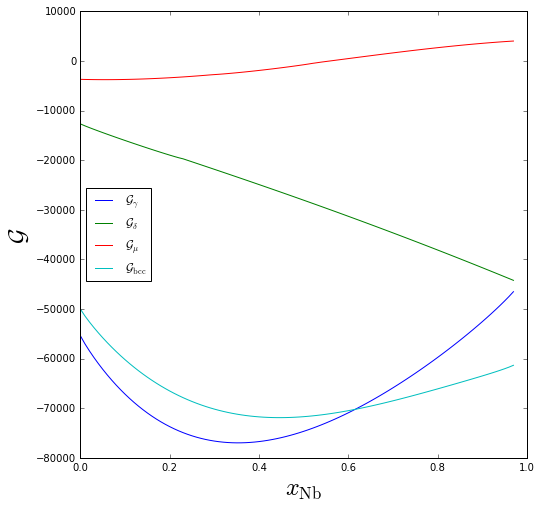

In [15]:
# plot Gibbs energy curves for fixed x_Mo = 2%
# Numerically efficient Gibbs energies
Gg = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
Gu = lambdify((MU_XMO, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

GX = []
GY = []
DX = []
DY = []
UX = []
UY = []
BX = []
BY = []

for xnb in np.linspace(epsilon,1,101):
    xmo = 0.02
    xni = 1-xmo-xnb
    #print "(%4.2f, %4.2f,%5.2f)"%(xmo,xnb,xni)
    if xni>0:
        UX.append(xnb)
        GY.append(Gg(xmo,xnb,xni))
        DY.append(Gd(xmo,xnb,xni))
        UY.append(Gu(xmo,xnb,xni))
        BY.append(Gb(xmo,xnb,xni))

plt.figure(figsize=(8, 8))
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$\mathcal{G}$', fontsize=24)
plt.plot(UX, GY, label=r'$\mathcal{G}_\gamma$')
plt.plot(UX, DY, label=r'$\mathcal{G}_\delta$')
plt.plot(UX, UY, label=r'$\mathcal{G}_\mu$')
plt.plot(UX, BY, label=r'$\mathcal{G}_\mathrm{bcc}$')
plt.legend(loc='best')

## Mathematica output

In [16]:
# from sympy.printing.mathematica import mathematica_code as mcode
# print "G_gamma:"
# print mcode(g_gamma)
# print "\nG_mu:"
# print mcode(g_mu)
# print "\nG_delta:"
# print mcode(g_delta)
# print "\nG_BCC:"
# print mcode(g_bcc)

## Partial Derivatives

In [17]:
# First derivatives
dGgam_dxMo = diff(g_gamma, GAMMA_XMO)
dGgam_dxNb = diff(g_gamma, GAMMA_XNB)
dGgam_dxNi = diff(g_gamma, GAMMA_XNI)

dGdel_dxMo = diff(g_delta, DELTA_XMO)
dGdel_dxNb = diff(g_delta, DELTA_XNB)
dGdel_dxNi = diff(g_delta, DELTA_XNI)

dGmu_dxMo = diff(g_mu, MU_XMO)
dGmu_dxNb = diff(g_mu, MU_XNB)
dGmu_dxNi = diff(g_mu, MU_XNI)

dGbcc_dxMo = diff(g_bcc, BCC_XMO)
dGbcc_dxNb = diff(g_bcc, BCC_XNB)
dGbcc_dxNi = diff(g_bcc, BCC_XNI)

# Second derivatives
d2Ggam_dxMo2 = diff(dGgam_dxMo, GAMMA_XMO)
d2Ggam_dxNb2 = diff(dGgam_dxNb, GAMMA_XNB)
d2Ggam_dxNi2 = diff(dGgam_dxNi, GAMMA_XNI)

d2Gdel_dxMo2 = diff(dGdel_dxMo, DELTA_XMO)
d2Gdel_dxNb2 = diff(dGdel_dxNb, DELTA_XNB)
d2Gdel_dxNi2 = diff(dGdel_dxNi, DELTA_XNI)

d2Gmu_dxMo2 = diff(dGmu_dxMo, MU_XMO)
d2Gmu_dxNb2 = diff(dGmu_dxNb, MU_XNB)
d2Gmu_dxNi2 = diff(dGmu_dxNi, MU_XNI)

d2Gbcc_dxMo2 = diff(dGbcc_dxMo, BCC_XMO)
d2Gbcc_dxNb2 = diff(dGbcc_dxNb, BCC_XNB)
d2Gbcc_dxNi2 = diff(dGbcc_dxNi, BCC_XNI)

## C output

In [18]:
codegen([# Gibbs energies
         ('g_gam',g_gamma), ('g_mu',g_mu), ('g_del',g_delta), ('g_bcc',g_bcc),
         # First derivatives
         ('dg_gam_dxMo',dGgam_dxMo), ('dg_gam_dxNb',dGgam_dxNb), ('dg_gam_dxNi',dGgam_dxNi),
         ('dg_del_dxMo',dGdel_dxMo), ('dg_del_dxNb',dGdel_dxNb), ('dg_del_dxNi',dGdel_dxNi),
         ('dg_mu_dxMo',dGmu_dxMo), ('dg_mu_dxNb',dGmu_dxNb), ('dg_mu_dxNi',dGmu_dxNi),
         ('dg_bcc_dxMo',dGbcc_dxMo), ('dg_bcc_dxNb',dGbcc_dxNb), ('dg_bcc_dxNi',dGbcc_dxNi),
         # Second derivatives
         ('d2g_gam_dxMo2',d2Ggam_dxMo2), ('d2g_gam_dxNb2',d2Ggam_dxNb2), ('d2g_gam_dxNi2',d2Ggam_dxNi2),
         ('d2g_del_dxMo2',d2Gdel_dxMo2), ('d2g_del_dxNb2',d2Gdel_dxNb2), ('d2g_del_dxNi2',d2Gdel_dxNi2),
         ('d2g_mu_dxMo2', d2Gmu_dxMo2),  ('d2g_mu_dxNb2', d2Gmu_dxNb2),  ('d2g_mu_dxNi2', d2Gmu_dxNi2),
         ('d2g_bcc_dxMo2',d2Gbcc_dxMo2), ('d2g_bcc_dxNb2',d2Gbcc_dxNb2), ('d2g_bcc_dxNi2',d2Gbcc_dxNi2)],
        language='C', prefix='energy625', project='ALLOY625', to_files=True)

# Generate a phase diagram

This system has Lagrangian energy density

$$\mathcal{L} = \sum_pn_pG_p - \sum_i\mu_i\left[\sum_pn_px_{p,i} - N_i\right]$$

with phase fraction $n_p$, Gibbs energies (per phase) $G_p$, chemical potentials (per species) $\mu_i$, and mole fractions (per species and per phase) $x_{p,i}$. Note that the $\mu_i$ are the Lagrange multipliers of the constraint of mass conservation.

To generate the phase diagram, this equation is solved for the equilibrium compositions, chemical potentials, and phase fractions, accomplished by setting the partial derivatives of $\mathcal{L}$ with respect to each unknown equal to zero. The $G_p$ are taken from the Calphad database, and $N_i$ are the system composition corresponding to a point on the Gibbs simplex.

Therefore, we have seven knowns:
* 4 from $G$ ($G_\gamma$, $G_\delta$, $G_\mu$, $G_\mathrm{BCC}$)
* 3 from $N$ ($N_\mathrm{Mo}$, $N_\mathrm{Nb}$, $N_\mathrm{Ni}$)

This leaves nineteen variables: 
* 3 from $\mu$ ($\mu_\mathrm{Mo}$, $\mu_\mathrm{Nb}$, $\mu_\mathrm{Ni}$)
* 4 from $n$ ($n_\gamma$, $n_\delta$, $n_\mu$, $n_\mathrm{BCC}$)
* 3 from $x_\gamma$ ($x_{\gamma,\mathrm{Mo}}$, $x_{\gamma,\mathrm{Nb}}$, $x_{\gamma,\mathrm{Ni}}$) 
* 3 from $x_\delta$ ($x_{\delta,\mathrm{Mo}}$, $x_{\delta,\mathrm{Nb}}$, $x_{\delta,\mathrm{Ni}}$) 
* 3 from $x_\mu$ ($x_{\mu,\mathrm{Mo}}$, $x_{\mu,\mathrm{Nb}}$, $x_{\mu,\mathrm{Ni}}$)
* 3 from $x_\mathrm{BCC}$ ($x_{\mathrm{BCC},\mathrm{Mo}}$, $x_{\mathrm{BCC},\mathrm{Nb}}$,  $x_{\mathrm{BCC},\mathrm{Ni}}$)

The partial derivatives below are taken in exactly the order the variables appear above, producing nineteen equilibrium equations. To accelerate convergence of scipy.optimize.fsolve, the Jacobian matrix $J_{ij}=\frac{\partial f_i}{\partial x_j}$ is also computed -- that is, the partial derivative of each of the nineteen equations is taken with respect to each of the nineteen unknowns, in the same variable order as given above. This makes a $19\times19$ square symmetric matrix of partial derivatives: one equation per row, one variable per column.

## Numerically efficient expressions

In [19]:
# Gibbs energies
Gg = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), g_gamma, modules='numpy')
Gd = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), g_delta, modules='numpy')
Gu = lambdify((MU_XMO, MU_XNB, MU_XNI), g_mu, modules='numpy')
Gb = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), g_bcc, modules='numpy')

# First derivatives
dgdx0 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxMo, modules='numpy')
dgdx1 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNb, modules='numpy')
dgdx2 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), dGgam_dxNi, modules='numpy')

dddx0 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxMo, modules='numpy')
dddx1 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNb, modules='numpy')
dddx2 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), dGdel_dxNi, modules='numpy')

dudx0 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxMo, modules='numpy')
dudx1 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNb, modules='numpy')
dudx2 = lambdify((MU_XMO, MU_XNB, MU_XNI), dGmu_dxNi, modules='numpy')

dbdx0 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxMo, modules='numpy')
dbdx1 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNb, modules='numpy')
dbdx2 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), dGbcc_dxNi, modules='numpy')

# Second derivatives
d2gdx20 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxMo2, modules='numpy')
d2gdx21 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNb2, modules='numpy')
d2gdx22 = lambdify((GAMMA_XMO, GAMMA_XNB, GAMMA_XNI), d2Ggam_dxNi2, modules='numpy')

d2ddx20 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxMo2, modules='numpy')
d2ddx21 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNb2, modules='numpy')
d2ddx22 = lambdify((DELTA_XMO, DELTA_XNB, DELTA_XNI), d2Gdel_dxNi2, modules='numpy')

d2udx20 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxMo2, modules='numpy')
d2udx21 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNb2, modules='numpy')
d2udx22 = lambdify((MU_XMO, MU_XNB, MU_XNI), d2Gmu_dxNi2, modules='numpy')

d2bdx20 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxMo2, modules='numpy')
d2bdx21 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNb2, modules='numpy')
d2bdx22 = lambdify((BCC_XMO, BCC_XNB, BCC_XNI), d2Gbcc_dxNi2, modules='numpy')

## Solver

In [ ]:
def commonTangentConc(C_Mo, C_Nb, C_Ni, guess):
    def equilibrium(u0, u1, u2, n0, n1, n2, n3, xg0, xg1, xg2, xd0, xd1, xd2, xu0, xu1, xu2, xb0, xb1, xb2):
        
        return [# dL/du
                -n0*xg0 - n1*xd0 - n2*xu0 - n3*xb0 + C_Mo,
                -n0*xg1 - n1*xd1 - n2*xu1 - n3*xb1 + C_Nb,
                -n0*xg2 - n1*xd2 - n2*xu2 - n3*xb2 + C_Ni,
                # dL/dn
                Gg(xg0,xg1,xg2) - u0*xg0 - u1*xg1 - u2*xg2,
                Gd(xd0,xd1,xd2) - u0*xd0 - u1*xd1 - u2*xd2,
                Gu(xu0,xu1,xu2) - u0*xu0 - u1*xu1 - u2*xu2,
                Gb(xb0,xb1,xb2) - u0*xb0 - u1*xb1 - u2*xb2,
                # dL/dxg
                n0*(dgdx0(xg0,xg1,xg2) - u0),
                n0*(dgdx1(xg0,xg1,xg2) - u1),
                n0*(dgdx2(xg0,xg1,xg2) - u2),
                # dL/dxd
                n1*(dddx0(xd0,xd1,xd2) - u0),
                n1*(dddx1(xd0,xd1,xd2) - u1),
                n1*(dddx2(xd0,xd1,xd2) - u2),
                # dL/dxu
                n2*(dudx0(xu0,xu1,xu2) - u0),
                n2*(dudx1(xu0,xu1,xu2) - u1),
                n2*(dudx2(xu0,xu1,xu2) - u2),
                # dL/dxb
                n3*(dbdx0(xb0,xb1,xb2) - u0),
                n3*(dbdx1(xb0,xb1,xb2) - u1),
                n3*(dbdx2(xb0,xb1,xb2) - u2)
                ]

    def Equilibrium(A):
        # Helper to convert from an array to named input
        return equilibrium(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13], A[14], A[15], A[16], A[17], A[18])

    def jacobian(u0, u1, u2, n0, n1, n2, n3, xg0, xg1, xg2, xd0, xd1, xd2, xu0, xu1, xu2, xb0, xb1, xb2):
        
        return[
            [0,   0,   0,   -xg0,-xd0,-xu0,-xb0,-n0,0,0,-n1,0,0,-n2,0,0,-n3,0,0],
            [0,   0,   0,   -xg1,-xd1,-xu1,-xb1,0,-n0,0,0,-n1,0,0,-n2,0,0,-n3,0],
            [0,   0,   0,   -xg2,-xd2,-xu2,-xb2,0,0,-n0,0,0,-n1,0,0,-n2,0,0,-n3],
            [-xg0,-xg1,-xg2,0,0,0,0,dgdx0(xg0,xg1,xg2)-u0,dgdx1(xg0,xg1,xg2)-u1,dgdx2(xg0,xg1,xg2)-u2,0,0,0,0,0,0,0,0,0],
            [-xd0,-xd1,-xd2,0,0,0,0,0,0,0,dddx0(xd0,xd1,xd2)-u0,dddx1(xd0,xd1,xd2)-u1,dddx2(xd0,xd1,xd2)-u2,0,0,0,0,0,0],
            [-xu0,-xu1,-xu2,0,0,0,0,0,0,0,0,0,0,dudx0(xu0,xu1,xu2)-u0,dudx1(xu0,xu1,xu2)-u1,dudx2(xu0,xu1,xu2)-u2,0,0,0],
            [-xb0,-xb1,-xb2,0,0,0,0,0,0,0,0,0,0,0,0,0,dbdx0(xb0,xb1,xb2)-u0,dbdx1(xb0,xb1,xb2)-u1,dbdx2(xb0,xb1,xb2)-u2],
            [-n0, 0,   0,   dgdx0(xg0,xg1,xg2)-u0,0,0,0,n0*d2gdx20(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0,0,0],
            [0,   -n0, 0,   dgdx1(xg0,xg1,xg2)-u1,0,0,0,0,n0*d2gdx21(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0,0],
            [0,   0,   -n0, dgdx2(xg0,xg1,xg2)-u2,0,0,0,0,0,n0*d2gdx22(xg0,xg1,xg2),0,0,0,0,0,0,0,0,0],
            [-n1, 0,   0,   0,dddx0(xd0,xd1,xd2)-u0,0,0,0,0,0,n1*d2ddx20(xd0,xd1,xd2),0,0,0,0,0,0,0,0],
            [0,   -n1, 0,   0,dddx1(xd0,xd1,xd2)-u1,0,0,0,0,0,0,n1*d2ddx21(xd0,xd1,xd2),0,0,0,0,0,0,0],
            [0,   0,   -n1, 0,dddx2(xd0,xd1,xd2)-u2,0,0,0,0,0,0,0,n1*d2ddx22(xd0,xd1,xd2),0,0,0,0,0,0],
            [-n2, 0,   0,   0,0,dudx0(xu0,xu1,xu2)-u0,0,0,0,0,0,0,0,n2*d2udx20(xu0,xu1,xu2),0,0,0,0,0],
            [0,   -n2, 0,   0,0,dudx1(xu0,xu1,xu2)-u1,0,0,0,0,0,0,0,0,n2*d2udx21(xu0,xu1,xu2),0,0,0,0],
            [0,   0,   -n2, 0,0,dudx2(xu0,xu1,xu2)-u2,0,0,0,0,0,0,0,0,0,n2*d2udx22(xu0,xu1,xu2),0,0,0],
            [-n3, 0,   0,   0,0,0,dbdx0(xb0,xb1,xb2)-u0,0,0,0,0,0,0,0,0,0,n3*d2bdx20(xb0,xb1,xb2),0,0],
            [0,   -n3, 0,   0,0,0,dbdx1(xb0,xb1,xb2)-u1,0,0,0,0,0,0,0,0,0,0,n3*d2bdx21(xb0,xb1,xb2),0],
            [0,   0,   -n3, 0,0,0,dbdx2(xb0,xb1,xb2)-u2,0,0,0,0,0,0,0,0,0,0,0,n3*d2bdx22(xb0,xb1,xb2)]
        ]

    def Jacobian(A):
        return jacobian(A[0], A[1], A[2], A[3], A[4], A[5], A[6], A[7], A[8], A[9], A[10], A[11], A[12], A[13], A[14], A[15], A[16], A[17], A[18])

    return fsolve(func=Equilibrium, x0=guess, fprime=Jacobian)

In [ ]:
XG = [] # array of Mo concentrations
YG = [] # array of Nb concentrations
XD = [] # (gamma, delta, mu, bcc)
YD = []
XU = []
YU = []
XB = []
YB = []

n = 0
density = 101

guess = (1,    1,     1,        # Mo, Nb, Ni potentials
         1/4,  1/4,   1/4, 1/4, # gamma, delta, mu, bcc fractions
         0.1,  0.05,  0.85,     # gamma comp
         0.2,  0.2,   0.6,      # delta comp
         0.01, 0.525, 0.465,    # mu comp
         0.5,  0.5,   0)        # bcc comp

for xnb in np.linspace(epsilon, 1, density):
    for xmo in np.linspace(epsilon, 1, density):
        xni = 1 - xmo - xnb
        if xni > 0:
            #try:
            equ0, equ1, equ2, \
            eqn0, eqn1, eqn2, eqn3, \
            eqxg0, eqxg1, eqxg2, \
            eqxd0, eqxd1, eqxd2, \
            eqxu0, eqxu1, eqxu2, \
            eqxb0, eqxb1, eqxb2 = commonTangentConc(xmo, xnb, xni, guess)
            #    break
            #except ValueError:
            #    print "ValueError occurred (probably log(0))"
            #    continue
            print "%6i: Comp. (%4.2f, %4.2f,%5.2f) ==> phase frac. (%5.2f gam,%5.2f del,%5.2f mu,%5.2f bcc)" % (n+1, xmo, xnb, xni, eqn0, eqn1, eqn2, eqn3)

            if eqxg0+epsilon>0 and eqxg1+epsilon>0 and eqxg2+epsilon>0 and eqxg0+eqxg1+eqxg2-epsilon<1:
                XG.append(eqxg1 + eqxg0/2)
                YG.append(rt32*eqxg0)

            if eqxd0+epsilon>0 and eqxd1+epsilon>0 and eqxd2+epsilon>0 and eqxd0+eqxd1+eqxd2-epsilon<1:
                XD.append(eqxd1 + eqxd0/2)
                YD.append(rt32*eqxd0)

            if eqxu0+epsilon>0 and eqxu1+epsilon>0 and eqxu2+epsilon>0 and eqxu0+eqxu1+eqxu2-epsilon<1:
                XU.append(eqxu1 + eqxu0/2)
                YU.append(rt32*eqxu0)

            if eqxb0+epsilon>0 and eqxb1+epsilon>0 and eqxb2+epsilon>0 and eqxb0+eqxb1+eqxb2-epsilon<1:
                XB.append(eqxb1 + eqxb0/2)
                YB.append(rt32*eqxb0)

            n+=1


/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


     1: Comp. (0.00, 0.00, 1.00) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
     2: Comp. (0.01, 0.00, 0.99) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
     3: Comp. (0.02, 0.00, 0.98) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)


/users/tnk10/.conda/envs/mmsp/lib/python2.7/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


     4: Comp. (0.03, 0.00, 0.97) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
     5: Comp. (0.04, 0.00, 0.96) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
     6: Comp. (0.05, 0.00, 0.95) ==> phase frac. ( 0.00 gam, 0.00 del,-0.00 mu,-0.00 bcc)
     7: Comp. (0.06, 0.00, 0.94) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu, 0.00 bcc)
     8: Comp. (0.07, 0.00, 0.93) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu, 0.00 bcc)
     9: Comp. (0.08, 0.00, 0.92) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
    10: Comp. (0.09, 0.00, 0.91) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
    11: Comp. (0.10, 0.00, 0.90) ==> phase frac. ( 0.00 gam, 0.00 del,-0.00 mu, 0.00 bcc)
    12: Comp. (0.11, 0.00, 0.89) ==> phase frac. ( 0.00 gam, 0.00 del,-0.00 mu,-0.00 bcc)
    13: Comp. (0.12, 0.00, 0.88) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu,-0.00 bcc)
    14: Comp. (0.13, 0.00, 0.87) ==> phase frac. ( 0.00 gam, 0.00 del, 0.00 mu, 0.00 bcc)
    15: Co

In [ ]:
# triangle bounding the Gibbs simplex
XT = [0.0, 1.0, 0.5, 0.0]
YT = [0.0, 0.0, rt32,0.0]

plt.figure(figsize=(8, 8))
#plt.axis('equal')
plt.xlim([0,1.125])
plt.ylim([0,1.125])
plt.xlabel(r'$x_\mathrm{Nb}$', fontsize=24)
plt.ylabel(r'$x_\mathrm{Mo}$', fontsize=24)
plt.plot(XT, YT, '-k')
plt.scatter(XG, YG, color='red', label=r'$\gamma$')
plt.scatter(XD, YD, color='green', label=r'$\delta$')
plt.scatter(XU, YU, color='blue', label=r'$\mu$')
plt.scatter(XB, YB, color='yellow', label='BCC')
plt.legend(loc='best')
plt.show()